In [1]:
from cProfile import label
import os
import json
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict
import pickle as pl

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

/tmp/ipykernel_2585988/508105282.py:26: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [19]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [18]:
# Data Loading with x0 and xT
class ODEDataSet():
      
    def __init__(self):
        
        # loading the csv file from the folder path
        data1 = np.loadtxt('ODE_records.csv', delimiter=',',
                           dtype=np.float32, skiprows=1)
          
        # here the 13th column is class label and rest 
        # are features
        self.x = torch.from_numpy(data1[:, [1]])
        self.y = torch.from_numpy(data1[:, [49]])
        self.n_samples = data1.shape[0] 
      
    # support indexing such that dataset[i] can 
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
dataset = ODEDataSet()
x0 = dataset.x
xt = dataset.y
x_train, x_test, y_train, y_test = train_test_split(x0, xt, test_size=0.1)

### Build a Custome Activation Function 

In [20]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [22]:
class IntWeight(ActivationFunction):

    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(IntWeight,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.1)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
    
        return x*self.alpha

In [23]:
act_fn_by_name = {
    "intweight": IntWeight
}

In [24]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    n = np.size(x)
    y = act_fn(x)
    y_true = x[0]*np.exp(-3*x)
    
    # Push x, y and gradients back to cpu for plotting
    x, y, y_true = x.cpu().numpy(), y.cpu().numpy(), y_true.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_true, linewidth=2, label="ture function")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions


## Plotting With differetn Act_Fn
# rows = math.ceil(len(act_fns)/2.0)
# fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
# for i, act_fn in enumerate(act_fns):
#     vis_act_fn(act_fn, ax[divmod(i,2)], x)
# fig.subplots_adjust(hspace=0.3)
plt.show()

TypeError: IntWeight.__init__() missing 1 required positional argument: 'in_features'

In [4]:
# Training Process
def train_model(model, trainloader):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training.
        trainloader - PyTorch dataloader for training data.
    '''
    # setup training
    train_loss_list = []
    val_loss_list = []
    # define loss function
    # criterion = nn.NLLLoss()
    criterion = nn.MSELoss()
    # define learning rate
    learning_rate = 0.03
    # define number of epochs
    epochs = 30
    # initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    test_loss_list = []
    train_loss_list = []
    for e in range(epochs):
        running_loss = 0
        test_loss = 0
        x_list=[]
        for x0, xt in trainloader:
            x0 = x0.view(x0.shape[0], -1)
            log_ps = model(x0)
            loss = criterion(log_ps[9], xt)
            ##save to list
            x_output=torch.stack(log_ps)

            x_list.append(x_output.detach().data.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_loss /= len(x_train)
            train_loss_list.append(running_loss)
            # else:
            # print out the loss to make sure it is decreasing
            print(f"Training loss: {running_loss}")

            # model(x_test)
            # test_loss=0
            with torch.no_grad():
                log_test = model(x_test)
                test_loss_ = criterion(log_test[9], y_test)
                test_loss += test_loss_.item()
                test_loss /= len(x_test)
                test_loss_list.append(test_loss)
                running_loss = test_loss
                # running_loss += test_loss.item()
                print(f"Test loss: {running_loss}")

    # Plot the loss
    pl.dump(x_list,open('./x_list.plk','wb'))
    np.savetxt('x_list.txt', np.hstack(x_list)[:, :, 0])
    x_np=np.hstack(x_list)
    ##x 1
    fig = plt.figure(figsize=(10, 5))
    plt.title("x_1 value in 100 epochs")
    plt.plot(x_np[0,:,:])
    fig.savefig('x_1', dpi=fig.dpi)
    
    fig = plt.figure(figsize=(10, 5))
    plt.title("Training Loss")
    plt.plot(train_loss_list, label="train")
    plt.plot(test_loss_list, label="test")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    fig.savefig('training loss.png', dpi=fig.dpi)

In [5]:
class intweight(nn.Module):
    
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(intweight,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.1)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
    
        return x*self.alpha

### Define the Network Structure

In [25]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=1, num_classes=1, hidden_sizes=[1, 1, 1, 1]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

### Model Saving and Loading 

In [ ]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [6]:
class ClassifierODEmodel(nn.Module):
    
    def __init__(self):
        super().__init__()

        # initialize layers fully connected 
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
        self.fc3 = nn.Linear(1,1)
        self.fc4 = nn.Linear(1,1)
        self.fc5 = nn.Linear(1,1)
        self.fc6 = nn.Linear(1,1)
        self.fc7 = nn.Linear(1,1)
        self.fc8 = nn.Linear(1,1)
        self.fc9 = nn.Linear(1,1)
        self.fc10 = nn.Linear(1,1)

        self.a1 = intweight(1)
        self.a2 = intweight(1)
        self.a3 = intweight(1)
        self.a4 = intweight(1)
        self.a5 = intweight(1)
        self.a6 = intweight(1)
        self.a7 = intweight(1)
        self.a8 = intweight(1)
        self.a9 = intweight(1)
        self.a10 = intweight(1)

    def forward(self, x):
        # make sure the input tensor is flattened
        # add the different activation function to 
        x = x.view(x.shape[0], -1)

        x1 = x + self.a1(nn.LeakyReLU(0.1)(self.fc1(x)))
        x2 = x1 + self.a2(nn.LeakyReLU(0.1)(self.fc2(x1)))
        x3 = x2 + self.a3(nn.LeakyReLU(0.1)(self.fc3(x2)))
        # print(x)
        x4 = x3 + self.a4(nn.LeakyReLU(0.1)(self.fc4(x3)))
        # print(x)
        x5 = x4 + self.a5(nn.LeakyReLU(0.1)(self.fc5(x4)))
        # print(x)
        x6 = x5 + self.a6(nn.LeakyReLU(0.1)(self.fc6(x5)))
        # print(x)
        x7 = x6 + self.a7(nn.LeakyReLU(0.1)(self.fc7(x6)))
        # print(x)
        x8 = x7 + self.a8(nn.LeakyReLU(0.1)(self.fc8(x7)))
        # print(x)
        x9 = x8 + self.a9(nn.LeakyReLU(0.1)(self.fc9(x8)))
        # print(x)
        x10 = x9 + self.a10(nn.LeakyReLU(0.1)(self.fc10(x9)))
    
        return x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 

Loading ODE dataset.

Training model with ODE stuff.

Training the model. Make sure that loss decreases after each epoch.

Training loss: 58.994552097963485
Test loss: 368.5297607421875
Training loss: 61.72543753291783
Test loss: 356.15077880859377
Training loss: 46.65182255091292
Test loss: 278.4968994140625
Training loss: 42.546694774841995
Test loss: 272.14348876953125
Training loss: 35.093832294592694
Test loss: 214.728076171875
Training loss: 33.80280075930477
Test loss: 210.086357421875
Training loss: 25.81933868065309
Test loss: 165.3022705078125
Training loss: 28.094628083304073
Test loss: 160.48022705078125
Training loss: 21.255879948648175
Test loss: 124.458349609375
Training loss: 18.723624308725423
Test loss: 119.2206640625
Training loss: 15.551944346910112
Test loss: 90.75016479492187
Training loss: 14.009923836354458
Test loss: 85.44849060058593
Training loss: 11.193813366836377
Test loss: 63.58882446289063
Training loss: 9.733473394158182
Test loss: 58.740291137695316
Tr

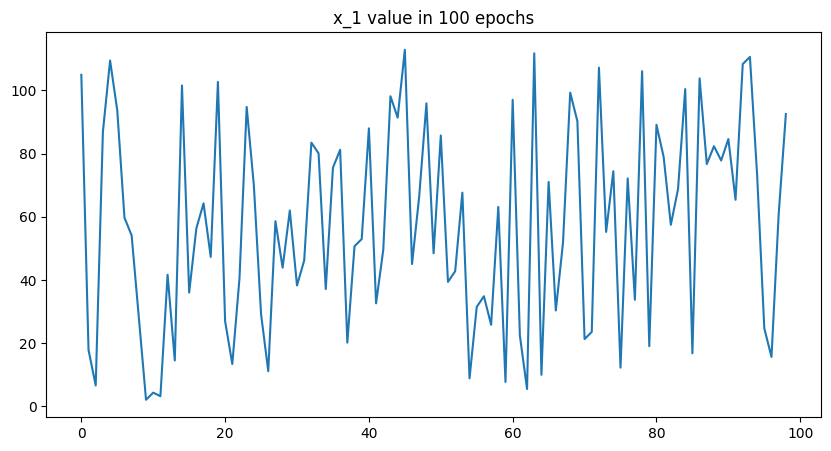

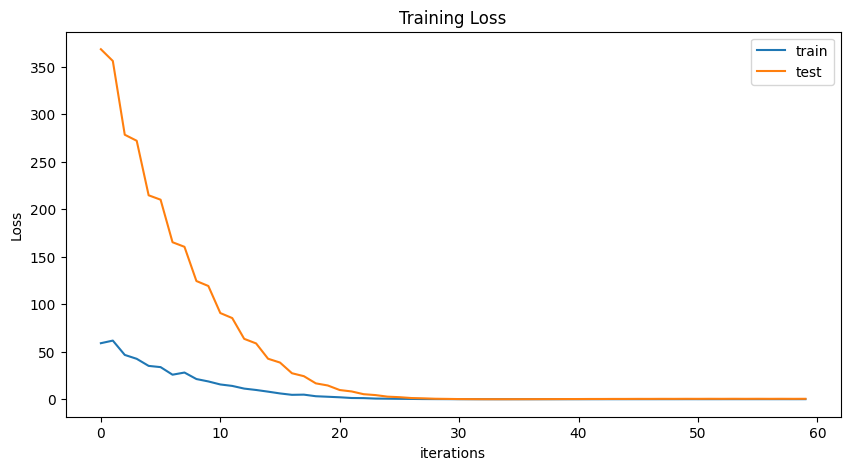

In [7]:
# Define the Mian

def main():
    print('Loading ODE dataset.\n')

    # Define a transform
    # transform = transforms.Compose([torch.tensor()])
    transform = transforms.Compose([transforms.ToTensor()])
    # Download and load the training data for Fashion MNIST
    #dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
    trainset = dataset
    #datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    # Save the model
    model = ClassifierODEmodel()
    Model_PATH = './ODE_10_model.pt'
    torch.save(ClassifierODEmodel,Model_PATH)
    
    # Save the parameters
    Parmater_PATH = './ODE_10_model.pth'
    
    # Run training
    print('Training model with ODE stuff.\n')
    train_model(model, trainloader)
    
    torch.save(model.state_dict(), Parmater_PATH)

    # load the model and evalute the data

    # model.load_state_dict(torch.load('./ODE_model.pt'))
    # model.eval()

if __name__ == '__main__':
    main()

### Plot Exist Model Parameters

In [8]:
model = ClassifierODEmodel()
Parameter_PATH = './ODE_10_model.pth'
model.load_state_dict(torch.load(Parameter_PATH))
model.eval()

ClassifierODEmodel(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
  (fc4): Linear(in_features=1, out_features=1, bias=True)
  (fc5): Linear(in_features=1, out_features=1, bias=True)
  (fc6): Linear(in_features=1, out_features=1, bias=True)
  (fc7): Linear(in_features=1, out_features=1, bias=True)
  (fc8): Linear(in_features=1, out_features=1, bias=True)
  (fc9): Linear(in_features=1, out_features=1, bias=True)
  (fc10): Linear(in_features=1, out_features=1, bias=True)
  (a1): intweight()
  (a2): intweight()
  (a3): intweight()
  (a4): intweight()
  (a5): intweight()
  (a6): intweight()
  (a7): intweight()
  (a8): intweight()
  (a9): intweight()
  (a10): intweight()
)

In [9]:
# Print Named Parameters
for name, para in model.named_parameters():
    print('{}: {}'.format(name, para.norm))

fc1.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-0.8832]], requires_grad=True)>
fc1.bias: <bound method Tensor.norm of Parameter containing:
tensor([-1.0839], requires_grad=True)>
fc2.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-1.5203]], requires_grad=True)>
fc2.bias: <bound method Tensor.norm of Parameter containing:
tensor([-1.7064], requires_grad=True)>
fc3.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-1.1112]], requires_grad=True)>
fc3.bias: <bound method Tensor.norm of Parameter containing:
tensor([-0.7492], requires_grad=True)>
fc4.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-0.1571]], requires_grad=True)>
fc4.bias: <bound method Tensor.norm of Parameter containing:
tensor([0.1232], requires_grad=True)>
fc5.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-1.2394]], requires_grad=True)>
fc5.bias: <bound method Tensor.norm of Parameter containing:
tensor([-0.0637], re

In [10]:
for name, para in model.named_parameters():
    if name == 'a1.alpha''a2.alpha':
        print('{}: {}'.format(name, para.norm))

In [11]:
import numpy as np
from numpy import genfromtxt
x_true = genfromtxt('ODE_records.csv', delimiter=',')
x = np.loadtxt("x_list.txt")

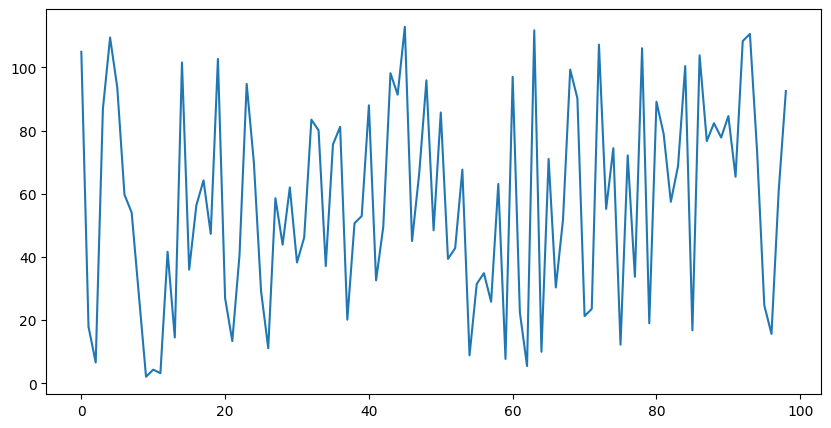

In [12]:
x.shape
fig = plt.figure(figsize=(10, 5))
plt.plot(x[0,:])

### Plot $x_1, x_{10}$ and ground truth

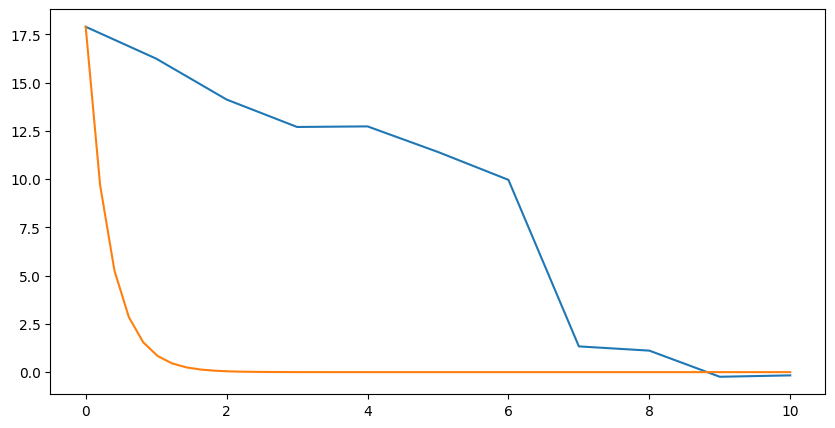

In [13]:
fig = plt.figure(figsize=(10, 5))
n = 1
plt.plot(x[:,n])
t = np.linspace(0,10)
y = x[0,n]*np.exp(-3*t)
# plt.plot(t,x_true[39,:])
plt.plot(t,y)

In [ ]:
torch.tensor.repeat()